In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


from sklearn.metrics import make_scorer

# 시계열

from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm


from sklearn.metrics import mean_absolute_error, mean_squared_error

data_dir='C:/Download/2020bigcontest-master/2020bigcontest-master/data/total'
data_list = os.listdir(data_dir)


#항목별 저장
data_list_single_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인타자')]
data_single_hitter = [pd.read_csv(os.path.join(data_dir, data_list_single_hitter[x]), encoding='cp949') for x in range(len(data_list_single_hitter))]
data_list_single_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('개인투수')]
data_single_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_single_pitcher[x]), encoding='cp949') for x in range(len(data_list_single_pitcher))]
data_list_games = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('경기')]
data_games = [pd.read_csv(os.path.join(data_dir, data_list_games[x]), encoding='cp949') for x in range(len(data_list_games))]
data_list_player_enroll = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('등록선수')]
data_player_enroll = [pd.read_csv(os.path.join(data_dir, data_list_player_enroll[x]), encoding='cp949') for x in range(len(data_list_player_enroll))]
data_list_players = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('선수')]
data_players = [pd.read_csv(os.path.join(data_dir, data_list_players[x]), encoding='cp949') for x in range(len(data_list_players))]
data_list_teams = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀')]
data_teams = [pd.read_csv(os.path.join(data_dir, data_list_teams[x]), encoding='cp949') for x in range(len(data_list_teams))]
data_list_team_hitter = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀타자')]
data_team_hitter = [pd.read_csv(os.path.join(data_dir, data_list_team_hitter[x]), encoding='cp949') for x in range(len(data_list_team_hitter))]
data_list_team_pitcher = [data_list[x] for x in range(len(data_list)) if data_list[x].split('_')[-2].startswith('팀투수')]
data_team_pitcher = [pd.read_csv(os.path.join(data_dir, data_list_team_pitcher[x]), encoding='cp949') for x in range(len(data_list_team_pitcher))]


team_hitter=pd.concat(data_team_hitter,axis=0)
team_pitcher=pd.concat(data_team_pitcher,axis=0)
for i in range(0,5):
     data_team_hitter[i]['AVG']=data_team_hitter[i]['HIT']/data_team_hitter[i]['AB']


from datetime import datetime as dt
from dateutil.parser import parse
team_2016=data_team_hitter[0]
team_2017=data_team_hitter[1]
team_2018=data_team_hitter[2]
team_2019=data_team_hitter[3]
team_2020=data_team_hitter[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]
for i in df_list:
    i['y']=i['HIT']/i['AB']
    
    i['ds']=pd.to_datetime(i['G_ID'].apply(lambda x: parse(str(x[:8])+str(x[12:])+'00000',yearfirst=True)),errors='raise')
    i['H1']=i['HIT']-i['H2']-i['H3']-i['HR']

In [3]:
team=pd.concat(df_list,axis=0)

In [4]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(inputSeries):
    result = adfuller(inputSeries)
    print('p-value: %f' % result[1])
    return result[1]

In [5]:
t=list(team_hitter['T_ID'].unique())
hit_team_list=[0]*10
for i in range(len(hit_team_list)):
    hit_team_list[i]=team_hitter[team_hitter['T_ID']==t[i]]

In [6]:

t=list(team_pitcher['T_ID'].unique())
pit_team_list=[0]*10
for i in range(len(pit_team_list)):
    pit_team_list[i]=team_pitcher[team_pitcher['T_ID']==t[i]]

In [14]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
def make_y_next(df, rm_range, target):
    df['y_next'] = 0
    
    t_dict = {}
    t_list = []
    count = 0
    f_count = 0
    for i, v in enumerate(df[target]):

        if df[target].index[i] == df[target].index[-1]:
            t_dict[str(f_count)] = round(np.mean(np.array(t_list)),5)

        t_list.append(v)
        count += 1

        if count == rm_range:
            t_dict[str(f_count)] = round(np.mean(np.array(t_list)),5)
            count = 0
            t_list = []
            f_count += 1

    rm_dict = {}
    rm_list = []
    rm_count = 0
    rm_fcount = 0

    for i, v in enumerate(df['y_next']):
        if df['y_next'].index[i] == df['y_next'].index[-1]:
            rm_dict[str(rm_fcount)] = rm_list

        rm_list.append(i)
        rm_count += 1

        if rm_count == rm_range:
            rm_dict[str(rm_fcount)] = rm_list
            rm_count = 0
            rm_list = []
            rm_fcount +=1

    for k, v in rm_dict.items():
        try:
            df['y_next'].iloc[v] = t_dict[str(int(k)+1)]
        except: 
            df['y_next'].iloc[v] = np.nan
            
    return df

# OUTLIER DETECTION-COLD GAME
- cold게임은 팀투수, 팀타자 데이터 모두에서 제거 할 것임.


In [21]:
#2017년 7월 2일 kt와 넥센의 경기 역시 강우콜드 처리되어 넥센이 승리를 가져갔다.
#이날 삼성 - SK 경기에선 5회 말 5대 6 리드 상황에서 우천 취소되어 SK가 이겼으며, 
#잠실에서 벌어진 KIA - LG의 경기 역시 강우콜드 선언이 되었다. 
team_2017[ (team_2017['GDAY_DS']==20170702)]
#즉,20170702WOKT0,20170702SSSK0,20170702HTLG0는 이상치로 간주하고 제거하는게 좋을 것 같다.

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG,y,ds,H1
766,20170702HTLG0,20170702,LG,HT,0,B,26,22,4,4,...,1,1,4,0.400000,10,4,0.363636,0.363636,2017-07-02,5
767,20170702HTLG0,20170702,HT,LG,0,T,41,34,12,13,...,0,0,8,0.333333,15,5,0.411765,0.411765,2017-07-02,9
768,20170702NCLT0,20170702,LT,NC,0,B,37,32,2,2,...,0,0,11,0.000000,7,0,0.250000,0.250000,2017-07-02,5
769,20170702NCLT0,20170702,NC,LT,0,T,36,30,1,1,...,1,2,8,0.000000,4,0,0.166667,0.166667,2017-07-02,5
770,20170702SSSK0,20170702,SK,SS,0,B,25,25,6,6,...,0,0,6,0.333333,12,4,0.480000,0.480000,2017-07-02,8
771,20170702SSSK0,20170702,SS,SK,0,T,29,24,5,5,...,1,0,9,0.250000,8,2,0.416667,0.416667,2017-07-02,6
772,20170702WOKT0,20170702,KT,WO,0,B,19,17,1,1,...,0,2,3,0.000000,3,0,0.176471,0.176471,2017-07-02,2
773,20170702WOKT0,20170702,WO,KT,0,T,30,27,5,5,...,0,0,7,0.400000,10,4,0.333333,0.333333,2017-07-02,6


2019년 4월 7일 한화 이글스와 롯데 자이언츠의 경기에서도 7회 초에 우천 중단 되었다가 콜드게임이 선언되었다. 이 당시 비구름이 올라오는 상황에 3회에서 한화가 한 이닝안에 16점의 대량 득점을 해내는 바람에 일부 롯데빠들은 빨리 비가 와 우천 취소되길 바라기도 했으나 정상적으로 6회를 넘겨버려 이뤄지지 않았다.

In [24]:

team_2019[ (team_2019['GDAY_DS']==20190407)&(team_2019['T_ID']=='HH')]
#즉 20190407HHLT0 경기는 이상치로 제거하고 진행하는게 좋을 것 같다.

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG,y,ds,H1
130,20190407HHLT0,20190407,HH,LT,0,T,39,36,16,16,...,2,0,5,0.6,15,9,0.527778,0.527778,2019-04-07,14


2020년 6월 10일 수원 케이티 위즈 파크에서 열린 KIA 타이거즈와 kt wiz의 경기에서도 KIA가 10대 0으로 크게 이기고 있는 상황에서 5회 말 종료 이후 우천 중단 되었다가 콜드게임이 선언되었다. 경기 전부터 비가 내리면서 경기 시작도 15분 늦어졌고, 경기를 하는 도중에도 꽤 많은 양의 비가 내려 선수들이 불편함을 호소하였다.

In [29]:
team_2020[ (team_2020['GDAY_DS']==20200610)&(team_2020['T_ID']=='HT')]
#즉 20200610HTKT0는 이상치

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN,AVG,y,ds,H1
307,20200610HTKT0,20200610,HT,KT,0,T,32,21,9,10,...,0,0,7,0.272727,11,3,0.333333,0.333333,2020-06-10,5


In [96]:
#최종적으로 콜드게임으로 인한 이상치로 규정한 경기들:
cold_list=['20170702WOKT0','20170702SSSK0','20170702HTLG0','20190407HHLT0','20200610HTKT0']

# OUTLIER DETECTION using IQR-팀타자
- 오직 팀타자 데이터 한정 이상치 제거
- 타깃 변수 및 운적인 요소를 많이 받는 지표들에 대해서 이상치 검정을 시행
- 만약 2개 이상의 변수에 대해 이상치 판정을 받는다면, 운 적인 요소가 많이 작용했던 경기로 간주하고  제거하는 방법 채택(n을 더 크게 설정하면 더 보수적인 이상치 선정이 됨)


In [124]:
team_2016=data_team_hitter[0]
team_2017=data_team_hitter[1]
team_2018=data_team_hitter[2]
team_2019=data_team_hitter[3]
team_2020=data_team_hitter[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]
team=pd.concat(df_list,axis=0)

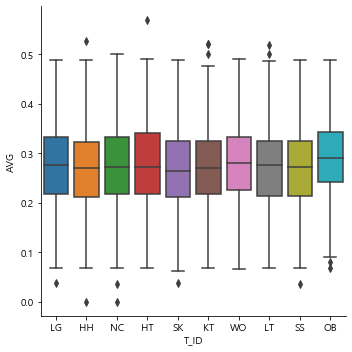

In [125]:
team_list=team['T_ID'].unique()

sns.factorplot(data=team,x='T_ID',y='AVG',kind='box')

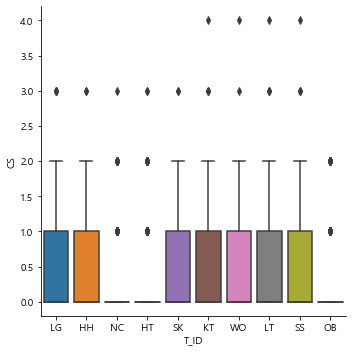

In [126]:
sns.factorplot(data=team,x='T_ID',y='CS',kind='box')

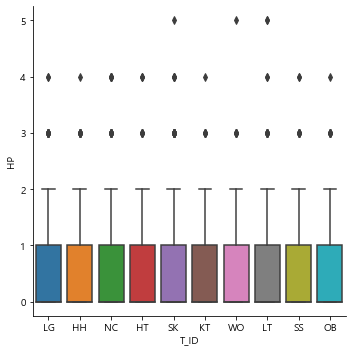

In [127]:
sns.factorplot(data=team,x='T_ID',y='HP',kind='box')

In [128]:
from collections import Counter
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    return multiple_outliers 

#운적인 지표 및 타율에 대해서만 이상치 제거 시행.
#2개 이상의 피쳐에 대해서 이상치가 발생했다면 이상치로 규정(운적인 요소가 많이 작용했을 가능성이 높기 때문에)


In [129]:
outlier_G_list_hitter=[]
for i in team_list:    
    Outliers_to_drop = detect_outliers(team[team['T_ID']==i], 2, [ 
       'CS',  'HP', 'ERR', 'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN'])
    ID=team[team['T_ID']==i].loc[Outliers_to_drop]['G_ID'].unique()
    outlier_G_list_hitter.extend(ID)
outlier_G_list_hitter.extend(cold_list)    

#고유값 갖게 하기 위해
outlier_G_list_hitter=list(set(outlier_G_list_hitter))

outlier_G_list_hitter

['20190825WOSS0',
 '20170702WOKT0',
 '20170930WONC0',
 '20190831WONC0',
 '20180811HTSK0',
 '20170708HTKT0',
 '20170521WOKT0',
 '20190630HTKT0',
 '20170719NCHH0',
 '20180904LGKT0',
 '20180613SKHT0',
 '20170702HTLG0',
 '20170617SKSS0',
 '20170702SSSK0',
 '20160831NCKT0',
 '20170917OBSS0',
 '20190823NCLG0',
 '20200625NCKT2',
 '20190515KTHT0',
 '20180915NCOB0',
 '20190820HTLG0',
 '20170919KTLG0',
 '20170818HHNC0',
 '20200610HTKT0',
 '20190928NCKT0',
 '20190407HHLT0']

# OUTLIER DETECTION using IQR-팀투수
- 보크, 폭투 변수 추가, 이에따라 n =3으로 더 보수적으로 선정해주기.

In [130]:
team_2016=data_team_pitcher[0]
team_2017=data_team_pitcher[1]
team_2018=data_team_pitcher[2]
team_2019=data_team_pitcher[3]
team_2020=data_team_pitcher[4]
df_list=[team_2016,team_2017,team_2018,team_2019,team_2020]
team=pd.concat(df_list,axis=0)

In [131]:
team

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,CG_CK,WLS,HOLD,INN2,...,KK,GD,WP,BK,ERR,R,ER,P_WHIP_RT,P2_WHIP_RT,CB_WHIP_RT
0,20160401HHLG0,20160401,LG,HH,0,B,0,W,0,36,...,10,1,0,0,0,4,4,0.642857,1.285714,2.400000
1,20160401HHLG0,20160401,HH,LG,0,T,0,L,0,34,...,11,0,1,0,0,5,4,1.500000,1.000000,0.750000
2,20160401HTNC0,20160401,NC,HT,0,B,0,W,0,27,...,10,1,2,0,0,4,4,1.333333,1.038462,2.142857
3,20160401HTNC0,20160401,HT,NC,0,T,0,L,0,24,...,9,1,0,0,0,5,5,0.500000,1.695652,1.875000
4,20160401KTSK0,20160401,SK,KT,0,B,0,L,0,27,...,7,0,0,0,0,8,8,1.000000,2.357143,2.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,20200719LTSS0,20200719,LT,SS,0,T,0,W,2,27,...,9,1,0,0,0,1,1,0.600000,1.111111,1.500000
636,20200719OBHT0,20200719,HT,OB,0,B,0,L,0,27,...,4,0,0,0,0,8,8,2.142857,1.800000,0.750000
637,20200719OBHT0,20200719,OB,HT,0,T,0,W,1,27,...,5,1,0,0,0,4,4,3.000000,1.000000,1.875000
638,20200719WOSK0,20200719,SK,WO,0,B,0,W,0,27,...,4,1,0,0,0,3,3,1.500000,1.105263,2.142857


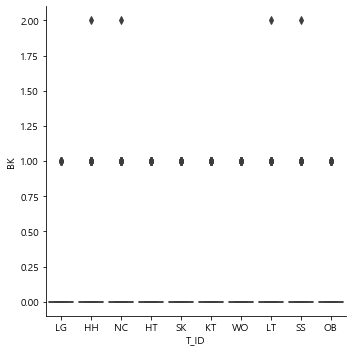

In [132]:
sns.factorplot(data=team,x='T_ID',y='BK',kind='box')

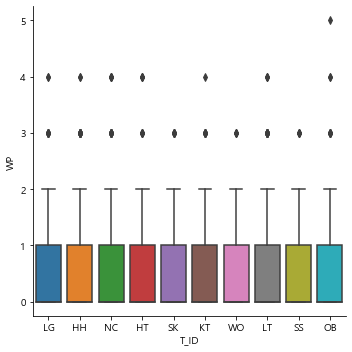

In [133]:
sns.factorplot(data=team,x='T_ID',y='WP',kind='box')

In [134]:
outlier_G_list_pitcher=[]
for i in team_list:    
    Outliers_to_drop = detect_outliers(team[team['T_ID']==i], 3, [ 
       'CS',  'HP', 'ERR', 'BK', 'WP','ER'])
    ID=team[team['T_ID']==i].loc[Outliers_to_drop]['G_ID'].unique()
    outlier_G_list_pitcher.extend(ID)
outlier_G_list_pitcher.extend(cold_list)    

#고유값 갖게 하기 위해
outlier_G_list_pitcher=list(set(outlier_G_list_pitcher))

outlier_G_list_pitcher

['20170702WOKT0',
 '20200705LGSS0',
 '20190608LTKT0',
 '20180426OBSK0',
 '20180422WOHH0',
 '20160408HTKT0',
 '20190521OBKT0',
 '20170502OBSS0',
 '20170702HTLG0',
 '20170702SSSK0',
 '20200512HTHH0',
 '20170616HHKT0',
 '20180610WOKT0',
 '20160619NCKT0',
 '20180529KTSS0',
 '20200610HTKT0',
 '20200602WOHH0',
 '20180523OBHH0',
 '20190407HHLT0',
 '20160505OBLG0']